In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from numpy.random import default_rng
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


In [2]:
time = '0'
day = '3'

In [3]:
path = os.path.join('./Data-mining', time, day)

In [4]:
percent = 0.3
tdriveGPS = os.listdir(path)
numfile = int(percent * len(tdriveGPS))

In [5]:
rng = default_rng()
idx = rng.choice([int(gps.split('.')[0]) for gps in tdriveGPS] , size=numfile, replace=False)

In [6]:
traj_data = []
for id in idx:
    filepath = os.path.join(path, str(id) + '.txt')
    with open(filepath, 'r') as f:
        traj = []
        for i, line in enumerate(f):
                if(i == 0): 
                     continue
                content = line.split(',')
                x, y = float(content[-2]), float(content[-1])
                traj.append([x, y])
        traj_data.append(np.array(traj))

In [7]:
import numpy as np

def is_zero_vector(v):
    """
    Checks if a vector is a zero vector.
    """
    return np.allclose(v, np.zeros(v.shape))

def is_nan(value):
    """
    Checks if a value is NaN (Not a Number).
    """
    return np.isnan(value).any()


def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector) # divide

def dist(A, B):
    return np.linalg.norm(A - B)

import warnings
# warnings.filterwarnings("ignore")

def angle_between(A, B, C, D):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1 = np.array(B) - np.array(A)
    v2 = np.array(D) - np.array(C)
    # compute
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    if(is_nan(v1_u) or is_nan(v2_u)):
        warnings.warn("NaN value detected in angle!")
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def angle_distance(A, B, C, D):
    angle = angle_between(A, B, C, D)
    scale = dist(A, B)
    try:
        assert angle >= 0 and angle <= np.pi
        assert scale >= 0
        if(angle <= np.pi / 2):
            return np.sin(angle) * scale
        return scale
    except Exception as e:
        print(e)
        print(angle, scale)
        assert 0

In [8]:
def perpendicular_distance(p, p1, p2):
    if np.array_equal(p1, p2):
        return np.linalg.norm(p - p1)
    return np.linalg.norm(np.cross(p2 - p1, p1 - p)) / np.linalg.norm(p2 - p1)

def mean_distance(A, B, C, D):
    l1 = perpendicular_distance(A, C, D)
    l2 = perpendicular_distance(B, C, D)
    assert l1 >= 0 and l2 >= 0
    if(l1 == 0 and l2 == 0):
        return np.array(0)
    return (l1**2 + l2**2) / (l1 + l2)

In [9]:
def define_log2(dist):
    assert dist >= 0
    return dist

In [10]:
def sum_replace_distance(trajectory, s, t):
    sum = dist(trajectory[s], trajectory[t])
    no_cost = 0
    if((trajectory[s] == trajectory[t]).all()):
        warnings.warn("Special case is detected in sum_replace_distance!")
        return (0, -1)

    for k in range(s, t):
        d_a = angle_distance(trajectory[k], trajectory[k+1], trajectory[s], trajectory[t])
        d_m = mean_distance(trajectory[k], trajectory[k+1], trajectory[s], trajectory[t])
        sum = define_log2(d_a) + define_log2(d_m) + sum
        no_cost = define_log2(dist(trajectory[k], trajectory[k+1])) + no_cost
    return (sum, no_cost)

In [11]:
def greedy_characteristic_points(trajectory, debug=False):
    # Initialize the characteristic points, add the first point as a characteristic point
    unique = []
    for p in trajectory:
        if(len(unique) == 0 or (p != unique[-1]).any()): unique.append(p)
    if(len(unique) <= 2): return np.array(unique)
    # assert len(unique) >= 2
    unique = np.array(unique)

    i = 0
    j = i + 1
    end = i
    cp = [0]
    while(j < len(unique)):
        tmp = sum_replace_distance(unique, i, j)
        j_is_cp = tmp[0]
        not_choose_j = tmp[1]
        if(debug): print(i, j, j_is_cp, not_choose_j, end="\n")
        if(j_is_cp <= not_choose_j): # better than
            end = j
            j += 1
        else:
            i = end + 1
            j = i + 1
            end = i
            cp.append(i)

    if(cp[-1] != len(unique) - 1): cp.append(len(unique) - 1) # add the last point as a characteristic point
    return np.array(unique)[cp]


In [12]:
def in_boundary(coor): # check if coordinates located in boundary
        if (coor[1] > 39 and coor[1] < 41.5) and (coor[0] > 116 and coor[0] < 117.5):
            return True
        return False

In [13]:
def preprocessing(trajs, threshold = 10): # delete oulier points and small traj

    newTraj = []
    for i in range(len(trajs)):

        curtraj = []

        for j in range(len(trajs[i])):
            if in_boundary(trajs[i][j]) == True:
                curtraj.append(trajs[i][j])
            else:
                if len(curtraj) >= threshold:
                    newTraj.append(np.array(curtraj))
                curtraj = []

        if len(curtraj) > threshold:
          newTraj.append(np.array(curtraj))
          curtraj = []

    return newTraj

In [14]:
def visualize_some_trajectory(data, num=5, legend=False):
    colors = ['r', 'g', 'b', 'c', 'm']
    trajectories = random.sample(data, num)

    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(trajectories):
        plt.plot(traj[:, 0], traj[:, 1], marker='o', color=colors[i % len(colors)], label=f'Trajectory {i+1}')

    plt.title('Original Trajectories')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    if(legend): plt.legend()
    plt.show()

    return trajectories

In [15]:
def to_segments(data):
    segments = []
    for traj in data:
        if(len(traj) < 2): continue
        for i in range(1, len(traj)):
            seg = np.array([traj[i-1], traj[i]])
            segments.append(seg)
    return np.array(segments)

In [16]:
def line_segment_clustering(vectors, C, min_samples):
    # Create a DBSCAN object with parameters
    dbscan = DBSCAN(eps=C, min_samples=min_samples)  # Adjust eps and min_samples as needed
    dbscan.fit(vectors)
    labels = dbscan.labels_
    # Identify noise points (cluster -1)
    noise_indices = np.where(labels == -1)[0]
    return labels, noise_indices


In [17]:
# Slope to angle in degrees
def slope_to_angle(slope, degrees=True):
    """
        Convert slope to angle in degrees.
    """
    if not degrees:
        return np.arctan(slope)
    return np.arctan(slope) * 180 / np.pi

# Slope to rotation matrix
def slope_to_rotation_matrix(slope):
    """
        Convert slope to rotation matrix.
    """
    return np.array([[1, slope], [-slope, 1]])

# Get cluster majority line orientation
def get_average_direction_slope(line_list):
    """
        Get the cluster majority line orientation.
        Returns 1 if the lines are mostly vertical, 0 otherwise.
    """
    # Get the average slopes of all the lines
    slopes = []
    for line in line_list:
        slopes.append((line[-1, 1] - line[0, 1]) / (line[-1, 0] - line[0, 0]) if (line[-1, 0] - line[0, 0]) != 0 else 0)
    slopes = np.array(slopes)

    # Get the average slope
    return np.mean(slopes)

# Trajectory Smoothing
def smooth_trajectory(trajectory, window_size=5):
    """
        Smooth a trajectory using a moving average filter.
    """
    # Ensure that the trajectory is a numpy array of shape (n, 2)
    if not isinstance(trajectory, np.ndarray):
        raise TypeError("Trajectory must be a numpy array")
    elif trajectory.shape[1] != 2:
        raise ValueError("Trajectory must be a numpy array of shape (n, 2)")

    # Ensure that the window size is an odd integer
    if not isinstance(window_size, int):
        raise TypeError("Window size must be an integer")
    elif window_size % 2 == 0:
        raise ValueError("Window size must be an odd integer")

    # Pad the trajectory with the first and last points
    padded_trajectory = np.zeros((trajectory.shape[0] + (window_size - 1), 2))
    padded_trajectory[window_size // 2:window_size // 2 + trajectory.shape[0]] = trajectory
    padded_trajectory[:window_size // 2] = trajectory[0]
    padded_trajectory[-window_size // 2:] = trajectory[-1]

    # Apply the moving average filter
    smoothed_trajectory = np.zeros(trajectory.shape)
    for i in range(trajectory.shape[0]):
        smoothed_trajectory[i] = np.mean(padded_trajectory[i:i + window_size], axis=0)

    return smoothed_trajectory

In [18]:
## NEW rep
def get_representative_trajectory(lines, min_lines=3):
    """
    Get the sweeping line vector average, optimized to O(n log n).
    """
    # Get the average rotation matrix for all the lines
    average_slope = get_average_direction_slope(lines)
    rotation_matrix = slope_to_rotation_matrix(average_slope)

    # Rotate all lines such that they are parallel to the x-axis
    rotated_lines = []
    for line in lines:
        rotated_lines.append(np.matmul(line, rotation_matrix.T))

    # Let starting_and_ending_points be the set of all starting and ending points of the lines
    starting_and_ending_points = []
    sto = {}
    id = 0
    for line in rotated_lines:
        starting_and_ending_points.append((line[0, 0], line[0, 1], line[-1, 0], line[-1, 1], id))
        starting_and_ending_points.append((line[-1, 0], line[-1, 1], line[0, 0], line[0, 1], id))
        id += 1

    # Sort the events by x-coordinate
    starting_and_ending_points.sort(key=lambda x: x[0])

    representative_points = []

    num_p = 0
    sum = 0
    # Sweep line algorithm using event list
    for event in starting_and_ending_points:
        x1, y1, x2, y2, idx = event

        val = sto.get(idx)
        if val == None:
            # Add the line y-coordinate to active lines
            sum += (y1 + y2)
            num_p += 1
            sto[idx] = True

        # If the number of active lines is greater than or equal to min_lines, calculate the average y
        if num_p >= min_lines:
            y_avg = sum / (num_p * 2)
            representative_points.append(np.array([x1, y_avg]))

        if val == True:
          # Remove the line y-coordinate from active lines
          num_p -= 1
          sum -= (y1 + y2)

    if len(representative_points) == 0:
        warnings.warn("WARNING: No representative points were found.")
        return np.array([])

    # Undo the rotation for the generated representative points
    representative_points = np.array(representative_points)
    representative_points = np.matmul(representative_points, np.linalg.inv(rotation_matrix).T)

    return representative_points


In [19]:
def extract_feature_vector(par):
    assert len(par) >= 2
    vectors = []
    for i in range(1, len(par)):
        direct = par[i] - par[i-1]
        lnorm = np.linalg.norm(direct)
        if(lnorm != 0):
            direct = direct / lnorm
        else:
            direct = np.array([0, 0])
        feat = np.array([par[i], par[i-1], direct]).flatten()
        feat = np.append(feat, lnorm)
        vectors.append(feat)
        assert len(feat) == 7

    scaler = StandardScaler()
    vectors = scaler.fit_transform(vectors)
    return np.array(vectors)

In [20]:
preprocessed_data = preprocessing(traj_data)

In [21]:
def line_segment_clustering(vectors, C, min_samples):
    # Create a DBSCAN object with parameters
    dbscan = DBSCAN(eps=C, min_samples=min_samples)  # Adjust eps and min_samples as needed
    dbscan.fit(vectors)
    labels = dbscan.labels_
    # Identify noise points (cluster -1)
    noise_indices = np.where(labels == -1)[0]
    return labels, noise_indices


In [22]:
vectors = None
for par in preprocessed_data:
    if(len(par) < 2): continue
    if(vectors is None):
        vectors = extract_feature_vector(par)
    else:
        tmp = extract_feature_vector(par)
        vectors = np.concatenate((vectors, tmp), axis=0)

In [23]:
cls = line_segment_clustering(vectors, C=10**0, min_samples=5)
print(f"With {10**0} is {np.unique(cls[0])} and {len(cls[1])}")

With 1 is [-1  0  1  2  3  4  5  6  7  8  9 10 11 12] and 1217


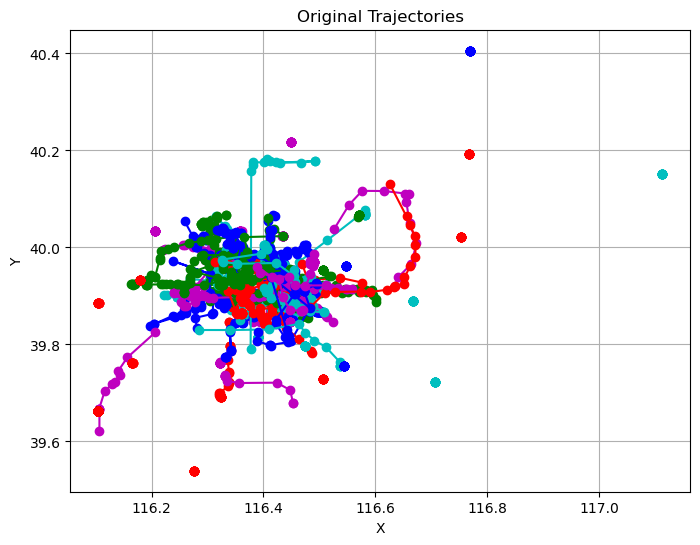

In [24]:
some_trajs = visualize_some_trajectory(preprocessed_data, 100)

In [25]:
segments = to_segments(preprocessed_data)

In [26]:
for cluster_id in range(0, 5):
    ids = np.where(cls[0] == cluster_id)[0].tolist()
    csegs = [segments[i] for i in ids]  # Use list comprehension
    print(cluster_id, len(csegs))

ids = np.where(cls[0] == 0)[0].tolist()
csegs = [segments[i] for i in ids]  # Use list comprehension

0 27851
1 11
2 25
3 5
4 19


In [27]:
rep = get_representative_trajectory(csegs)
rep = smooth_trajectory(rep, window_size=21)

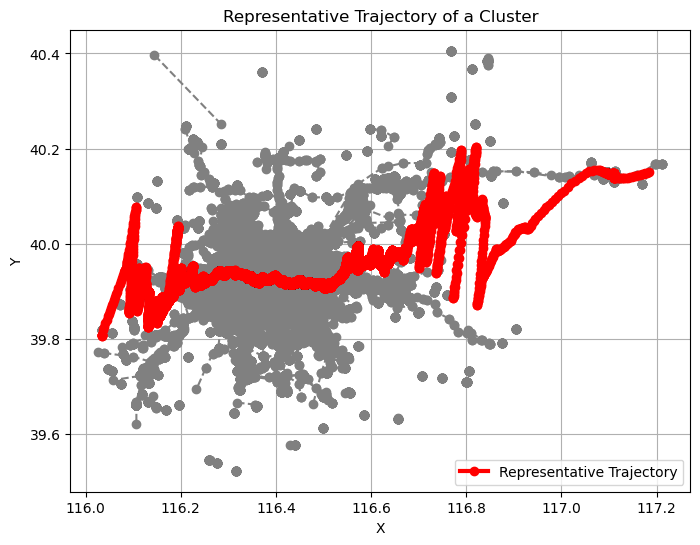

In [28]:
# Visualize the representative trajectory along with the original segments
plt.figure(figsize=(8, 6))

# Plot the original segments
for start, end in csegs:
    plt.plot([start[0], end[0]], [start[1], end[1]], 'gray', linestyle='--', marker='o')

# Plot the representative trajectory
plt.plot(rep[:, 0], rep[:, 1], 'r', linewidth=3, marker='o', label="Representative Trajectory")

plt.title('Representative Trajectory of a Cluster')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

In [29]:
print(len(csegs))

27851


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


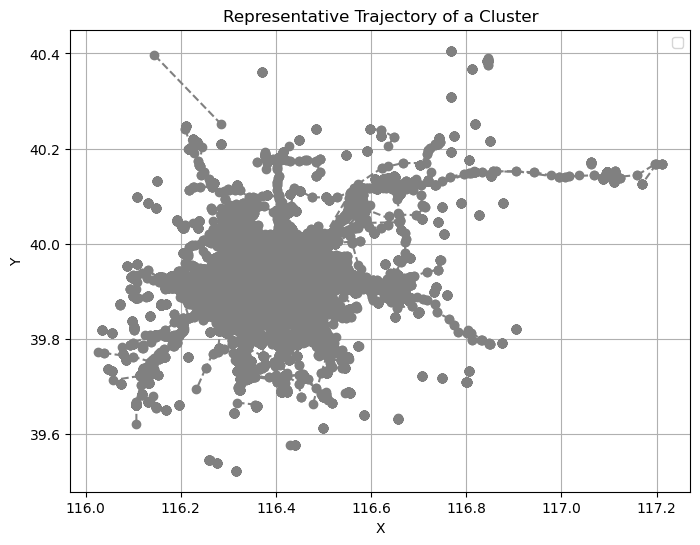

In [30]:
# Visualize the representative trajectory along with the original segments
plt.figure(figsize=(8, 6))

# Plot the original segments
for start, end in csegs:
    plt.plot([start[0], end[0]], [start[1], end[1]], 'gray', linestyle='--', marker='o')

# Plot the representative trajectory
#plt.plot(rep[:, 0], rep[:, 1], 'r', linewidth=3, marker='o', label="Representative Trajectory")

plt.title('Representative Trajectory of a Cluster')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()

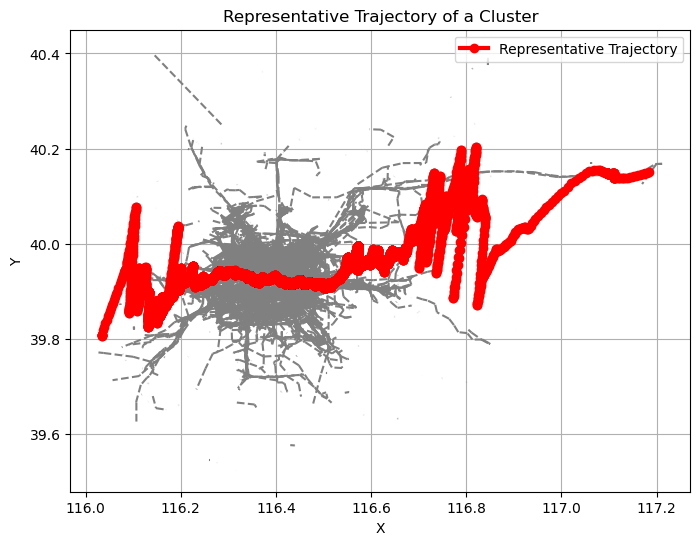

In [33]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Use LineCollection for faster rendering
line_segments = LineCollection(csegs, colors='gray', linestyle='--')
plt.gca().add_collection(line_segments)

# Plot the representative trajectory
plt.plot(rep[:, 0], rep[:, 1], 'r', linewidth=3, marker='o', label="Representative Trajectory")

plt.title('Representative Trajectory of a Cluster')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()
